In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import collections
import re
import pprint as pp
import numpy as np
import multiprocessing as mp
from multiprocessing import Process

import math
import gzip
import pickle as pkl
import time

from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import SGDClassifier

import fonctions
import batch_processing
import metric_loading

import random
import os
random.seed(0)

from os import listdir
from tqdm.notebook import tqdm
from os.path import isfile, join
from multiprocessing.pool import ThreadPool


Using TensorFlow backend.


In [2]:
##### CALIBRATION OF THE CLASSIFIER

def read_batch(directory, doc_name):
    
    df = pd.read_csv(directory+doc_name, encoding="utf-8", sep=',', header=0, index_col=False,low_memory=False)
    df = df.drop(df.columns[ [0] ], axis=1)
    df.index = df.tweet_id+'-'+df.engaging_user_id
    
    labels= ['like_timestamp','retweet_timestamp','retweet_with_comment_timestamp','reply_timestamp']

    X = df.drop( ['author_engagement',  'user_engagement',
                  'mean_daily_author_presence','std_daily_author_presence',
                  'language','tweet_id','tweet_timestamp','tweet_utctimestamp',
                  'engaged_with_user_account_creation', 'text_tokens',
                  'present_links','present_domains','hashtags',
                  'engaging_user_account_creation', 'present_media',
                  'engaged_with_user_id', 'engaging_user_id' ],axis=1)

    
    #X = X.drop(['first_author_link','link_in_total','hashtag_in_total','domain_in_total'],axis=1)
    X = shuffle(X, random_state=0)
    
    nan_cols = [i for i in X.columns if X[i].isnull().any() ]
    
    #########################################################
    ###### no a priori model
    
    X1 = X[  ~(X[ nan_cols ].notnull().all(1) ) ]
    y1=X1.filter( labels, axis=1 )
    X1 = X1.drop(labels,axis=1)
    
    ##########################################################
    ###### a priori model
    
    X2 = X[  X[ nan_cols ].notnull().all(1) ]
    y2 = X2.filter(labels, axis=1)
    X2 = X2.drop(labels,axis=1)

    return X1, y1, X2, y2

def load_model(model_id):
    with gzip.open('/home/maxime/Desktop/RecSys2020/modeles/model_multilabel_NN_{}.pkl.gz'.format(model_id), 'rb') as f:
            classifier = pkl.load(f)        
    return classifier

def classifier_calibration(directory, chunk, model_id):
    
    classifier1 = load_model(model_id)
    classifier2 = load_model(str(model_id)+'_wpriori')
    sc = StandardScaler()
    targets = ['like_timestamp','retweet_timestamp','retweet_with_comment_timestamp','reply_timestamp']
    
    iteration=1
    
    for clb_batch in chunk:
        
        X_clb1, y_clb1, X_clb2, y_clb2 = read_batch(directory, clb_batch)
        
        
        #########################################################
        ###### train no a priori model
        
        X_clb1 = X_clb1.drop(['author_ratio_like', 'author_ratio_retweet', 'author_ratio_rtc', 'author_ratio_reply',
                          'user_ratio_like', 'user_ratio_retweet', 'user_ratio_rtc', 'user_ratio_reply',
                          'content_link', 'content_text', 'content_photo_video', 'content_gif',
                          'taste_rt_author','taste_rtc_author','taste_rpl_author','taste_lk_author',
                          'taste_rt_hashtag','taste_rtc_hashtag','taste_rpl_hashtag','taste_lk_hashtag',
                          'taste_rt_domain', 'taste_rtc_domain', 'taste_rpl_domain', 'taste_lk_domain' ],axis=1)
            
        index1 =X_clb1.index
        X_clb1 = sc.fit_transform(X_clb1) 
        y_pred1 = classifier1.predict_proba(X_clb1,verbose=1)
        y_pred1 = y_pred1.astype('float64')
        y_pred1 = pd.DataFrame(y_pred1)  
        y_pred1.columns = ['pred_like','pred_retweet','pred_rtc','pred_rpl']
        y_pred1.index=index1
        
        resultat1 = pd.concat( [y_clb1,y_pred1], axis=1)
        
        #########################################################
        ###### train a priori model
        
        index2 = X_clb2.index
        X_clb2 = sc.fit_transform(X_clb2) 
        y_pred2 = classifier2.predict_proba(X_clb2,verbose=1)
        y_pred2 = y_pred2.astype('float64')
        y_pred2 = pd.DataFrame(y_pred2)  
        y_pred2.columns = ['pred_like','pred_retweet','pred_rtc','pred_rpl']
        y_pred2.index=index2
        
        resultat2 = pd.concat( [y_clb2, y_pred2], axis=1)
        
        resultat = pd.concat([resultat1,resultat2], axis=0)
        print(len(resultat.index))
        
        resultat.to_csv('/home/maxime/Desktop/RecSys2020/data/calibration_results/calibraton_{}.csv'.format(model_id),
            header=None, index=None, sep=',', mode='a')
        print(iteration)
        iteration=iteration+1
        
        
    return True

In [3]:
%%time

batch_path='/home/maxime/Desktop/RecSys2020/data/processed_batches/to_do/'
chunk = [f for f in listdir(batch_path) if isfile(join(batch_path, f))]

directory = '/home/maxime/Desktop/RecSys2020/data/processed_batches/to_do/'
model_id=209

classifier_calibration(directory, chunk[:200], model_id)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
4733/4733 [==============================] - 0s 30us/step
30000
1
4675/4675 [==============================] - 0s 19us/step
30000
2
4738/4738 [==============================] - 0s 17us/step
30000
3
4878/4878 [==============================] - 0s 16us/step
30000
4
4732/4732 [==============================] - 0s 16us/step
30000
5
4691/4691 [==============================] - 0s 16us/step
30000
6
4663/4663 [==============================] - 0s 16us/step
30000
7
4785/4785 [==============================] - 0s 18us/step
30000
8
4686/4686 [==============================] - 0s 20us/step
30000
9
4728/4728 [==============================] - 0s 15us/step
30000
10
4734/4734 [==============================] - 0s 17us/step
30000
11
4778/4778 [==============================] - 0s 18us/step
30000
12
4780/4780 [==============================] - 0s 16us/step
30000
13
4566/4566 [=======

True

In [4]:
from sklearn.linear_model import LogisticRegression as LR

model_id=209

df = pd.read_csv('/home/maxime/Desktop/RecSys2020/data/calibration_results/calibraton_{}.csv'.format(model_id),
                 encoding="utf-8", sep=',', header=None, index_col=False)

df.columns = ['like_timestamp','retweet_timestamp','retweet_with_comment_timestamp','reply_timestamp','pred_like','pred_retweet','pred_rtc','pred_rpl']

targets = ['like_timestamp','retweet_timestamp','retweet_with_comment_timestamp','reply_timestamp']

like_lr = LR()  
like_lr.fit( np.array(df['pred_like']).reshape(-1, 1), df['like_timestamp'] ) 
    
retweet_lr = LR()
retweet_lr.fit( np.array(df['pred_retweet']).reshape(-1, 1), df['retweet_timestamp'] ) 
  
rpl_lr = LR()
rpl_lr.fit( np.array(df['pred_rtc']).reshape(-1, 1), df['retweet_with_comment_timestamp'] ) 

rtc_lr = LR()
rtc_lr.fit( np.array(df['pred_rpl']).reshape(-1, 1), df['reply_timestamp'] ) 
    
calibrators = {'like_timestamp':like_lr,'retweet_timestamp':retweet_lr,
               'retweet_with_comment_timestamp':rpl_lr,'reply_timestamp':rtc_lr}

with gzip.open('/home/maxime/Desktop/RecSys2020/modeles/calibrators_{}.pkl.gz'.format(model_id),'wb') as f:
        pkl.dump(calibrators,f)

In [3]:
def calibration_effect(directory, chunk, model_id):
    
    
    classifier1 = load_model(model_id)
    classifier2 = load_model(str(model_id)+'_wpriori')
    calibrators = load_calibrators(model_id)
    sc = StandardScaler()
    iteration=1
    targets = ['like_timestamp','retweet_timestamp','retweet_with_comment_timestamp','reply_timestamp']

    iteration=1
    for clb_batch in chunk:

        X_clb1, y_clb1, X_clb2, y_clb2 = read_batch(directory, clb_batch)
        y_clb = pd.concat([y_clb1,y_clb2],axis=0)
        
        #########################################################
        ###### train no a priori model
        
        X_clb1 = X_clb1.drop(['author_ratio_like', 'author_ratio_retweet', 'author_ratio_rtc', 'author_ratio_reply',
                          'user_ratio_like', 'user_ratio_retweet', 'user_ratio_rtc', 'user_ratio_reply',
                          'content_link', 'content_text', 'content_photo_video', 'content_gif',
                          'taste_rt_author','taste_rtc_author','taste_rpl_author','taste_lk_author',
                          'taste_rt_hashtag','taste_rtc_hashtag','taste_rpl_hashtag','taste_lk_hashtag',
                          'taste_rt_domain', 'taste_rtc_domain', 'taste_rpl_domain', 'taste_lk_domain' ],axis=1)
        
        index1 = X_clb1.index    
        X_clb1 = sc.fit_transform(X_clb1) 
        
        y_pred1 = classifier1.predict_proba(X_clb1,verbose=1)
        y_pred1 = y_pred1.astype('float64')
        
        d1 = {'Tweet_Id': [ x.split('-')[0] for x in index1 ], 'User_Id': [ x.split('-')[1] for x in index1 ],
              'like_timestamp':y_pred1[:,0],'retweet_timestamp':y_pred1[:,1],'retweet_with_comment_timestamp':y_pred1[:,2],'reply_timestamp':y_pred1[:,3] }
        result1 = pd.DataFrame(data=d1)

        
        #########################################################
        ###### train a priori model
        
        index2 = X_clb2.index
        X_clb2 = sc.fit_transform(X_clb2)
        
        y_pred2 = classifier2.predict_proba(X_clb2,verbose=1)
        y_pred2 = y_pred2.astype('float64')
        
        d2 = {'Tweet_Id': [ x.split('-')[0] for x in index2 ], 'User_Id': [ x.split('-')[1] for x in index2 ],
              'like_timestamp':y_pred2[:,0],'retweet_timestamp':y_pred2[:,1],'retweet_with_comment_timestamp':y_pred2[:,2],'reply_timestamp':y_pred2[:,3] }
        result2 = pd.DataFrame(data=d2)

        resultat = pd.concat([result1,result2], axis=0)
        
        resultat.columns = ['Tweet_Id','User_Id']+targets

        
        for idx, engagement in enumerate(targets):
            
            print('pre-calibration: ' + str( fonctions.compute_rce(resultat[engagement], y_clb[engagement]) ) )
        
            y_hat = calibrators[engagement].predict_proba( np.array(resultat[engagement]).reshape(-1, 1) )[:,1]
            y_hat = y_hat.astype('float64') 
            
            print('post-calibration: ' + str( fonctions.compute_rce(y_hat, y_clb[engagement]) ) )
        
        print(iteration)
        iteration=iteration+1

    return True

def load_calibrators(model_id):
    with gzip.open('/home/maxime/Desktop/RecSys2020/modeles/calibrators_{}.pkl.gz'.format(model_id), 'rb') as f:
            calibrators = pkl.load(f)        
    return calibrators



In [6]:
batch_path='/home/maxime/Desktop/RecSys2020/data/processed_batches/to_do'
chunk = [f for f in listdir(batch_path) if isfile(join(batch_path, f))]

batch_path2='/home/maxime/Desktop/RecSys2020/data/processed_batches/to_do/'
chunk2 = [f for f in listdir(batch_path) if isfile(join(batch_path, f))]

liste = [x for x in chunk if x not in chunk2[:50] ]

directory = '/home/maxime/Desktop/RecSys2020/data/processed_batches/to_do/'
model_id=209

calibration_effect(directory, liste[:50], model_id)

4657/4657 [==============================] - 0s 42us/step
pre-calibration: -46.73583872684179
post-calibration: 2.936439836794247
pre-calibration: -12.744040125358724
post-calibration: 2.036426310260586
pre-calibration: -31.935420534707546
post-calibration: 0.31557183323427385
pre-calibration: -55.75472807997131
post-calibration: 1.73925458739006
1
4704/4704 [==============================] - 0s 18us/step
pre-calibration: -47.98894853576612
post-calibration: 2.9925560116092043
pre-calibration: -12.055545861900807
post-calibration: 2.1439055691147013
pre-calibration: -38.810783749339286
post-calibration: 0.17833697472630083
pre-calibration: -51.12047560777005
post-calibration: 2.254119781970443
2
4868/4868 [==============================] - 0s 19us/step
pre-calibration: -46.69637417261831
post-calibration: 3.207679551893572
pre-calibration: -12.829799271008646
post-calibration: 2.175120513673745
pre-calibration: -43.698172180603436
post-calibration: 0.18162012726531396
pre-calibration: 

KeyboardInterrupt: 

In [9]:
directory = '/home/maxime/Desktop/RecSys2020/data/validation_results/'
targets = ['like_timestamp','retweet_timestamp','retweet_with_comment_timestamp','reply_timestamp']
model_id=209

calibrators = load_calibrators(model_id)

for idx, target in enumerate(targets):
    print(target)
    
    print('load...')
    df = pd.read_csv(directory+target+'_'+str(model_id)+'.csv', encoding="utf-8", sep=',', header=None, index_col=False, low_memory=True)
    df.columns = ['Tweet_Id','User_Id']+[target]

    print('predict...')
    y_hat = calibrators[target].predict_proba( np.array(df[target]).reshape(-1, 1) )[:,1] 
    y_hat = y_hat.astype('float64') 
    df[target]=y_hat
    
    print('save...')
    df.to_csv('/home/maxime/Desktop/RecSys2020/data/calibration_results/{}_{}_cal.csv'.format(target,model_id),
        header=None, index=None, sep=',', mode='a')


like_timestamp
load...
predict...
save...
retweet_timestamp
load...
predict...
save...
retweet_with_comment_timestamp
load...
predict...
save...
reply_timestamp
load...
predict...
save...


In [2]:
rt = pd.read_csv('/home/maxime/Desktop/RecSys2020/data/validation_results/final10_retweet_timestamp_3000.csv', encoding="utf-8", sep=',', header=None, index_col=False, low_memory=True)
rtc = pd.read_csv('/home/maxime/Desktop/RecSys2020/data/validation_results/final10_retweet_with_comment_timestamp_3000.csv', encoding="utf-8", sep=',', header=None, index_col=False, low_memory=True)


FileNotFoundError: [Errno 2] No such file or directory: '/home/maxime/Desktop/RecSys2020/data/validation_results/final10_retweet_timestamp_3000.csv'

In [10]:
len( rtt[  rtt[2]>0.5 ] ) 

552016

In [9]:
len( rtv[  rtv[2]>0.5 ] )

627052

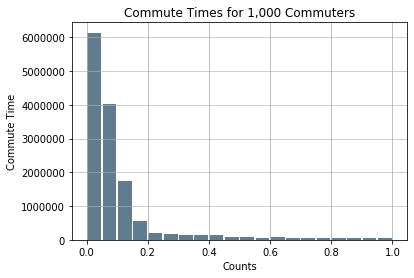

In [13]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series( rtv[2] )

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

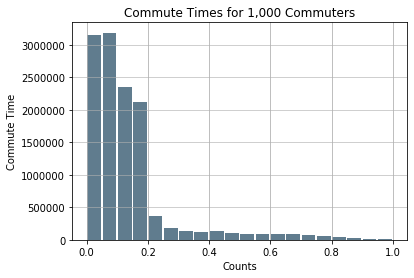

In [14]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series( rtt[2] )

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

In [5]:
# model_id=205
# rt = pd.read_csv('/home/maxime/Desktop/RecSys2020/data/validation_results/article_retweet_timestamp_3000.csv', encoding="utf-8", sep=',', header=None, index_col=False, low_memory=True)
# rtc = pd.read_csv('/home/maxime/Desktop/RecSys2020/data/validation_results/article_retweet_with_comment_timestamp_3000.csv', encoding="utf-8", sep=',', header=None, index_col=False, low_memory=True)
# rt = pd.concat([rt,rtc[2]],axis=1)
rt.columns=['a','b','rt','lab','rtc']

In [15]:
rt[ (rt['rtc']>0.5) & (rt['rt']<0.5) ]

,a,b,rt,rtc
56192,A078557614529FD4415ED92DCE45374A,4BA43D5ACB8F52CEA752D5AFCF23F010,0.469256,0.510508
147929,C61B6FF8DE00729E626053901C04B84B,0F825FECAEAA0673D0E356BD2506739A,0.428356,0.548387
327365,991D53C5B55F936D5FBB46A78369D217,158ED19824271780740797EFEE5FB7C7,0.468711,0.684828
328678,2019A04F0AF6971C5C58D3C90CA08C80,16DAF8B189B0802861873D7139D71176,0.389838,0.504376
448643,6C3A21F36E53270E75ABFF472E3216D2,24293C4D72B1FDC1E961F3F5E45F71B1,0.419319,0.554715
...,...,...,...,...
13763876,EEFD89492DA3D636B41B8A88836EC6A5,7F3FB09A27F9E138A00803FF24420D4E,0.496790,0.622021
13765980,41B185EB2466DA116278634EDDA85A80,807C7FA0AA98571F3107916829BBC1EB,0.463557,0.720169
13882517,BE0692072458AA7162A6EF74EFA2A6FE,7392529ACED8B9EC8DA75C3ED303F23B,0.458982,0.714070
13912686,BBBAC47F6CEFA5DC20F5B741188962C6,C59D2992753CA765A9595491D36C6FCB,0.488068,0.611141


In [16]:
rt[ rt['rtc']>rt['rt'] ]

,a,b,rt,rtc
24517,759F3F15D4F41EE014218D3B5A48F900,C6CB23B8289722A9C4F99C627C947A0B,0.021934,0.024146
24570,C713E9D01D427BB3A507FDA28929748F,C68740CFA28AF12B1A11A57DBCF2589C,0.133341,0.151098
24800,CD24C6C68B845A5CE37186B70EBAB74F,C626BED877D47FBE0C23AAB06BAD5821,0.046147,0.046631
24967,EB819F2B934D5D1CBD5580BCDF521789,C68B3B05D269FAFDC119D7667BBF06CA,0.238980,0.329283
25090,607F355C97F722B4439DAEBEA344E982,C74AA351EA2C0029C72F01DBA9FF77E6,0.231200,0.412413
...,...,...,...,...
13945150,BC22BC3ED1BD61D059B9CDDA00327615,6B79058D73B1EACBA21AEEAB74FA1B7F,0.033272,0.054068
13945394,3DBB5D51B7EB6050201C69A21D78769B,6B7E9A5CF6366A463BEC7F1DE1F20507,0.011894,0.021644
13947006,3DA614B2460332B765B550F5CD8A8032,6B79058D73B1EACBA21AEEAB74FA1B7F,0.016405,0.021200
13947253,67054794290BF0EEC63B4E8845E63A3E,6BDC91F75C860ABAD803B5A206464AAF,0.176297,0.214122
